
Mixture of Gaussians
======
Feature Selection an Expectation-Maximization algorithm for Mixture of Gaussians from scratch using numpy and jax


In [1]:
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as jnp
import jax
import numpy as np

Data Generation for Mixture of Gaussians
====

Create a Data to work in two classes

In [2]:
def GenerateData(n_samples: int, n_classes: int, dim: int)-> (jnp, jnp):
    """
    Valance Data Generation 
    """
    key = jax.random.PRNGKey(0)
    Total_Data = [] 
    Total_Y = []
    for idx in range(n_classes):
        keys = random.split(key, 1)
        X = random.normal(keys[0], (dim, n_samples)) + idx*7*jnp.ones((dim, 1))
        Y = idx*jnp.ones(n_samples)
        Total_Data.append(X)
        Total_Y.append(Y)
    return jnp.hstack(Total_Data), jnp.hstack(Total_Y)

n_samples=200
X, Y = GenerateData(n_samples=n_samples, n_classes=2, dim=2)

In [3]:
#normalize data
X1=(X[0,:]-jnp.min(X[0,:]))/(jnp.max(X[0,:])-jnp.min(X[0,:]))
X2=(X[1,:]-jnp.min(X[1,:]))/(jnp.max(X[1,:])-jnp.min(X[1,:]))
X_Normalized= np.vstack([X1, X2]) 
print('el shape de X1 es:',X1.shape,'el shape de y es:',Y.shape)

el shape de X1 es: (400,) el shape de y es: (400,)


shapes (2, 200) (2, 200)


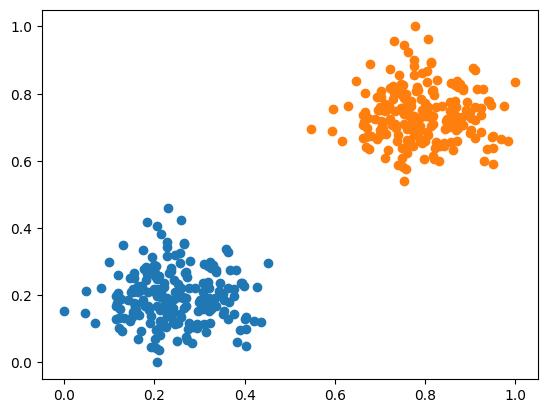

In [4]:
#-----Separate the data in classes -------
plt.figure(1)
X_1=X_Normalized[:,:n_samples]    #samples tipo(x,y) que perteneces a clase 1
X_2=X_Normalized[:,n_samples:]     #samples tipo(x,y) que perteneces a clase 2
print('shapes', X_2.shape,X_2.shape)
plt.scatter(X_1[0],X_1[1])
plt.scatter(X_2[0],X_2[1])

In [5]:
#------this is if you want to generate random valanced data, but i will not use it, because is more interesting unbalanced data 
#key = jax.random.PRNGKey(0)
#keys = jax.random.split(key, 1)
#nitial_Values=jnp.array(jax.random.normal(keys[0], (2,)))

Let's goin to create a simple unbalanced data for two classes

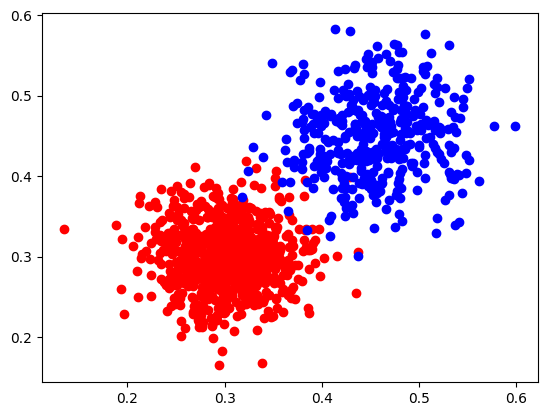

In [6]:
X_1 = np.random.normal(loc=0.3,scale=0.04,size=(2,800)) 
X_2 = np.random.normal(loc=0.45,scale=0.05,size=(2,400)) 
plt.figure() 
plt.plot(X_1[0,:], X_1[1,:], 'ro') 
plt.plot(X_2[0,:], X_2[1,:], 'bo') 

Compute the Gamma function for the E-Step

In [32]:

def gamma_fun(TotalClasses,mus,sigmas,pis):
    '''  
    This function calculates the gamma probability and N_k (the sum of gammas for each class) 
    args: 
        TotalClasses: List of NDarrays, each array is a class with the data of the class 
        mus: Tuple of NDarrays, each array have the mu of each class of shape (NumberOfFeatures,1)
        sigmas: Tuple of NDarrays, each array have the sigma of each class of shape (NumberOfFeatures,NumberOfFeatures)
        pis: Tuple of floats, each float is the pi of each class (you can start with => (Number of samples in each class/total samples)

    return: 
        gamma_k: array of gamma probability of shape (samples,number of classes ) 
        N_k: NDarray of floats, each float is the sum of gamma for each class
    ''' 

    NumberOfFeatures=len(TotalClasses[0][:,0])  #numero de features ex.2
    ShapeVectores=max([len(TotalClasses[0][0,:]),len(TotalClasses[1][0,:])])
    NumberOfClasses=len(TotalClasses)   #numero de clases ex.2

    #------Is to compute the denominator of gamma probability ->  sum_k(Pi_k * N(x|mu_k,sigma_k)) ---------------
    denominador_gamma_array=np.zeros(shape=(ShapeVectores,NumberOfClasses))
    for each_clase in range(len(TotalClasses)):     #is for the sum of each x \times with the normal of each class
        denominador_gamma_array_k=np.zeros(shape=(ShapeVectores,2))  #clean the array for each class
        p_classe=pis[each_clase]
        sigma=sigmas[each_clase]
        mu=np.reshape(mus[each_clase],(NumberOfFeatures,1))     #reshape para evitar tener (NumberOfFeatures,)
        determinante_sigma=np.linalg.det(sigma)
        inv_sigma=np.linalg.inv(sigma)
        for clase in range(len(TotalClasses)):  #is for the x who lives in each X_class
            TamañoClase=len(TotalClasses[clase][0,:])
            for element in range(TamañoClase):  #element inside X_class (ex. X_class1 or X_class2)
                current_x=np.reshape(TotalClasses[clase][:,element],(NumberOfFeatures,1))
                gaussian=(1/(np.sqrt(2*np.pi)**(len(TotalClasses))*determinante_sigma))*np.exp(-1/2*(np.transpose(current_x-mu)@(inv_sigma)@(current_x-mu)))
                denominador_gamma_array_k[element,clase]=p_classe*gaussian
        denominador_gamma_array=denominador_gamma_array+denominador_gamma_array_k     
    
    #------Compute Gamma probabilitie and N_k  ->    gamma_ik= pi*N(x|mu_k,sigma_k) / sum_k(Pi_k * N(x|mu_k,sigma_k))  and N_k=sum(Kamma_k) -----------------
    gamma_k=np.zeros(shape=(ShapeVectores,NumberOfFeatures))
    N_k=np.zeros(shape=(len(TotalClasses)))
    for clase in range(len(TotalClasses)):
        TamañoClase=len(TotalClasses[clase][0,:])
        N_k[clase]=0
        p_classe=pis[clase]
        sigma=sigmas[clase]
        mu=np.reshape(mus[clase],(NumberOfFeatures,1))     #reshape para evitar tener (2,)
        determinante_sigma=np.linalg.det(sigma)
        inv_sigma=np.linalg.inv(sigma)
        for element in range(TamañoClase):
            current_x=np.reshape(TotalClasses[clase][:,element],(NumberOfFeatures,1))
            gaussian=(1/(np.sqrt(2*np.pi)**(len(TotalClasses))*determinante_sigma))*np.exp(-1/2*(np.transpose(current_x-mu)@(inv_sigma)@(current_x-mu)))
            gamma_probaility=p_classe* gaussian/denominador_gamma_array[element,clase]
            gamma_k[element,clase]=gamma_probaility
            N_k[clase]= N_k[clase] + gamma_probaility

    return gamma_k,N_k


In [8]:
def M_step(TotalClasses,N_k,gamma_k):
    '''  
    This function compute de M step of the EM algorithm 
    args: 
        TotalClasses: List of NDarrays, each array is a class with the data of the class 
        N_k: NDarray of floats, each float is the sum of gamma for each class
        gamma_k: Array of gamma probability of shape (samples,number of classes )
    return: 
        mus: Tuple of NDarrays, each array have the mu of each class of shape (NumberOfFeatures,1)
        sigmas: Tuple of NDarrays, each array have the sigma of each class of shape (NumberOfFeatures,NumberOfFeatures)
        pis: Tuple of floats, each float is the pi of each class (you can start with => (Number of samples in each class/total samples)
    ''' 

    NumberOfFeatures=len(TotalClasses[0][:,0])  #numero de features ex.2
    #Compute the news mu_k y pi_km  ->  mu_k=(1/N_k)* sum_i (Gamma_ik *x_i)   and pi= N_k/ Total num of data  ------------------------------
    mus=[]
    pis=[]
    for clase in range(len(TotalClasses)):
        TamañoClase=len(TotalClasses[clase][0,:])
        pis.append(N_k[clase]/([len(TotalClasses[0][0,:])+len(TotalClasses[1][0,:])]))
        mu_k=np.zeros(shape=(NumberOfFeatures,1))
        for element in range(TamañoClase):   
            current_x=np.reshape(TotalClasses[clase][:,element],(NumberOfFeatures,1))
            gamma_probaility=gamma_k[element,clase]
            new_mu=(1/N_k[clase])*gamma_probaility*current_x
            mu_k=mu_k+new_mu
        mu_k=np.reshape(mu_k,(NumberOfFeatures,))   #lo regresamos a su forma original ya que gamma function requiere este formato
        mus.append(mu_k)

    # compute the new sigmas ->  sigma_k=(1/N_k)* sum_i (Gamma_ik * (x_i-mu_k) * (x_i-mu_k)^T)   --------------------------
    sigmas=[]
    for clase in range(len(TotalClasses)):
        sigma_k=np.zeros(shape=(NumberOfFeatures,NumberOfFeatures)) 
        TamañoClase=len(TotalClasses[clase][0,:])     
        for element in range(TamañoClase):
            current_x=np.reshape(TotalClasses[clase][:,element],(NumberOfFeatures,1))
            gamma_probaility=gamma_k[element,clase]         
            new_sigma=(1/N_k[clase])*gamma_probaility*(current_x-mus[clase])@np.transpose(current_x-mus[clase])
            sigma_k=sigma_k+new_sigma
        sigmas.append(sigma_k)

    return mus,sigmas,pis


In [9]:
#------ EM algorithm----------------
def GaussianMixtureModel(mus,sigmas,pis,TotalClasses,NumberOfSteps):
    '''  
    This function compute de M step of the EM algorithm 
    args: 
        mus: Tuple of NDarrays, each array have the mu of each class of shape (NumberOfFeatures,1)
        sigmas: Tuple of NDarrays, each array have the sigma of each class of shape (NumberOfFeatures,NumberOfFeatures)
        pis: Tuple of floats, each float is the pi of each class (you can start with => (Number of samples in each class/total samples)
        TotalClasses: List of NDarrays, each array is a class with the data of the class
        NumberOfSteps: Number of steps to run the EM algorithm
    return: 
        mus: New Mu's -Tuple of NDarrays, each array have the mu of each class of shape (NumberOfFeatures,1)
        sigmas: New Sigmas's - Tuple of NDarrays, each array have the sigma of each class of shape (NumberOfFeatures,NumberOfFeatures)
        pis: New Pi's -Tuple of floats, each float is the pi of each class (you can start with => (Number of samples in each class/total samples)
    ''' 
    contador=0
    while contador<NumberOfSteps:
        gamma_k,N_k=gamma_fun(TotalClasses,mus,sigmas,pis)
        mus,sigmas,pis=M_step(TotalClasses,N_k,gamma_k)
        contador+=1
    return mus,sigmas,pis

Testing the EM algorith for a Mixture of Gaussians, calling the previos funtions and the previous Data generated

In [31]:
#------Inicial values for two classes----------------
TotalClasses=[X_1,X_2]

mu_1=np.array([(0.1),(0.2)])
mu_2=np.array([(0.3),(0.4)])
sigmas_1=np.identity(2)
sigmas_2=np.identity(2)

mus=(mu_1, mu_2)
sigmas=(sigmas_1,sigmas_2)
pis=(0.5, 0.5)

mus,sigmas,pis=GaussianMixtureModel(mus,sigmas,pis,TotalClasses,NumberOfSteps=2)
print('the mus,sigmas and  pis are:',mus,sigmas,pis)

los mus,sigmas y pis finales son: [array([0.3007129 , 0.29822696]), array([0.45822381, 0.45366541])] [array([[ 0.00299154, -0.00015273],
       [-0.00015273,  0.00311159]]), array([[ 4.31011767e-03, -8.47788891e-05],
       [-8.47788891e-05,  5.04115933e-03]])] [array([0.65733082]), array([0.31533502])]


Funtion to create a plot of the Gaussians using the obtained mu's, sigmas's and Pi's

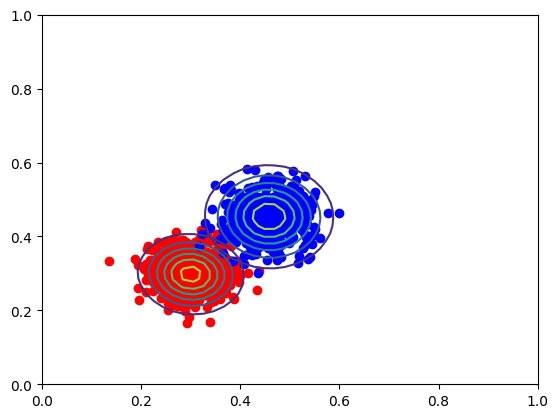

In [11]:
def gaussianPltFunction(mus,sigmas):
    mu_gaussian_1=mus[0]
    mu_gaussian_2=mus[1]
    sigma_gaussian_1=sigmas[0]
    sigma_gaussian_2=sigmas[1]
    plt.figure(1)
    # Plotting first Gaussian
    m = np.array(mu_gaussian_1)  # defining the mean of the Gaussian 
    cov = np.array(sigma_gaussian_1)   # defining the covariance matrix
    cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
    cov_det = np.linalg.det(cov)  # determinant of covariance matrix

    x = np.linspace(0, 1) # defining the x axis from 0 to 1 (because we have normalized the data)
    y = np.linspace(0, 1)
    X,Y = np.meshgrid(x,y)
    coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
    Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))
    plt.contour(X,Y,Z)

    # Plotting second Gaussian
    m = np.array(mu_gaussian_2)  # defining the mean of the Gaussian (mX = 0.2, mY=0.6)
    cov = np.array(sigma_gaussian_2)   # defining the covariance matrix
    cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
    cov_det = np.linalg.det(cov)  # determinant of covariance matrix

    x = np.linspace(0, 1)
    y = np.linspace(0, 1)
    X,Y = np.meshgrid(x,y)
    coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
    Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))
    plt.contour(X,Y,Z)


#-----plot of the samples----------------
plt.figure(1) 
plt.plot(X_1[0,:], X_1[1,:], 'ro') 
plt.plot(X_2[0,:], X_2[1,:], 'bo') 
gaussianPltFunction(mus,sigmas)
plt.show()

Feature Selection
====

This Section is to create a feature selection of a dataset using Secuencial backward selection

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Load the csv to python using pandas and numpy

In [13]:
#cargamos los datos para meterlos a los modelos converimos a jax numpy array
Clean_df=pd.read_csv("clean_data.csv")
Clean_df = Clean_df.drop(Clean_df.columns[0], axis=1)

Clean_df.loc[Clean_df['class'] == -1, 'class'] = 0
Clean_df.loc[Clean_df['class'] == 1, 'class'] = 1

class_df=Clean_df.loc[:, "class"]
df_without_class = Clean_df.drop(["class"], axis=1)
#---------------------------------------------------------------------------------------------------------------------------------
#-------------------- Nota importante---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------
#df_without_class only first 6 columns------ NOTA: opcion para probar con columnas que no son solo 0 o 1 (por el one hot encoding), sino comentar solamente
#y se realizará feature selection sobre todas las columnas, aunque esto tiene un inconveniente, ya que al tratar con columnas que no son solo 0 o 1, no es 
#posible ver la data en el espacio de los features como aproximaciones de gausiannas para su predicción.
df_without_class=df_without_class.iloc[:,0:6]

X=df_without_class.to_numpy()
y=class_df.to_numpy()

Split the data into TRAIN,TEST,VAL

In [14]:
#-----------split the data into 70% train 20% validation and 10% test---------
#first divide into 70% train and 30% test+val
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True, stratify=None)

X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=1/3,
                                                  random_state=1,shuffle=True, stratify=None) # 0.3 x 1/3 = 0.1

In [15]:
print(X.shape)
print('X_test',X_train.shape,y_train.shape)

(45222, 6)
X_test (31655, 6) (31655,)


In [16]:
#--------------separamos los datos de train en sus dos respectivas clases--------------------
df_x=pd.DataFrame(X_train)
df_y=pd.DataFrame(y_train, columns=['y'])
df=pd.concat([df_x, df_y], axis=1)
df1_X_class_1= df[df['y'] ==0 ]
df1_X_class_1 = df1_X_class_1.drop(df1_X_class_1.columns[-1],axis=1) #quitamos ultima columna relacionada a y
df1_X_class_2= df[df['y'] ==1 ]
df1_X_class_2 = df1_X_class_2.drop(df1_X_class_2.columns[-1],axis=1)

#reconvert to numpy array
X_class_1=df1_X_class_1.to_numpy()
X_class_2=df1_X_class_2.to_numpy()

I gonna use Secuencial backward selection as feature selection method

In [17]:
from itertools import combinations

Defining some functions to use secuencial backward

(split the data, agroup in all posible combinationsof features, find the max norm or separation between classes for heach group, choose the best group and repeat)

In [18]:
def FirstSplit(X_toSplit,inicial_group_features_number):
    '''This function splits the data into small groups, and is only used in the first iteration of the algorithm 
    to reduce substantially the number of features when we have a lot of features.'''
    group=np.hsplit(X_toSplit, inicial_group_features_number)
    column_names=list(range(0,X_toSplit.shape[1]))
    column_names=np.array_split(column_names, inicial_group_features_number)
    return group,column_names

def CombinatorialGroups(X_toSplit,size, num_elements_in_group, column_names):
    lista_index=list(range(0,size)) 
    dimmension=X_toSplit.shape  #saple,numero de grupos  
    index_permutations=list(combinations(lista_index, num_elements_in_group)) 
    groups=[]
    new_columns_names=[]
    for group in range(size): #size=numero de grupos
        current_list_index=index_permutations[group] # tiene numero de features -1  
        group_k=np.zeros((dimmension[0],num_elements_in_group))
        for feature in range(num_elements_in_group):
            group_k[:,feature]=X_toSplit[:,current_list_index[feature]]         
        new_group_columns_names=[]
        for index in current_list_index:
            new_group_columns_names.append(column_names[index])
        new_columns_names.append(new_group_columns_names)
        groups.append(group_k)
    return groups,new_columns_names

def mu_calculation(Maingroup):
    number_of_groups=len(Maingroup[:])
    features=len(Maingroup[0][0,:]) #primer indice es el primer array luego de hsplit y luego los otros son para ingresar al array y sus features y datos
    mu=np.zeros((number_of_groups,features))
    for group in range(number_of_groups):
        for feature in range(features):
            mu[group,feature]=np.mean(Maingroup[group][:,feature])
    return mu    

def Norm_betweet_classes(mu_class_1,mu_class_2):
    number_of_groups=mu_class_1.shape[0]    #8grupos shape(13,8) 13 grupos con 8 features
    list_of_norm=[]
    for group in range(number_of_groups):
        Norm_betweet_classes=np.linalg.norm(np.abs(mu_class_1[group,:]-mu_class_2[group,:]))
        list_of_norm.append(Norm_betweet_classes)
    return list_of_norm

def GetNamesOfFeatures(column_names,df):
    list_of_names_df= list(df)
    real_names=[]
    for i in range(len(column_names)):
        real_names.append(list_of_names_df[column_names[i]])
    return real_names

Funtion to call in in the correct order the previous functions

In [19]:
def feature_selection(X_class_1,X_class_2,first_split,DesireFeatures):
    count=0
    while True:
        if count==0:
            groups_class_1,column_names_class_1=FirstSplit(X_class_1,first_split) #nota: la relacion entre num features/inicial_group_features_number tiene que ser int 104/13=8
            groups_class_2,column_names_class_2=FirstSplit(X_class_2,first_split)
        mu_class_1=mu_calculation(groups_class_1)
        mu_class_2=mu_calculation(groups_class_2)

        list_of_norm=Norm_betweet_classes(mu_class_1,mu_class_2)
        #print('la lista de normas es',list_of_norm)
        max_norm=max(list_of_norm)
        #print('la norma maxima es',max_norm)
        index_max_norm=list_of_norm.index(max_norm)

        winner_group_class_1=groups_class_1[index_max_norm]
        winner_group_class_2=groups_class_2[index_max_norm]
        winner_name_class_1=column_names_class_1[index_max_norm]
        winner_name_class_2=column_names_class_2[index_max_norm]
        
        number_features_in_group=len(groups_class_1[index_max_norm][0,:])
        
        if number_features_in_group==DesireFeatures: 
            return winner_group_class_1,winner_group_class_2,winner_name_class_1,winner_name_class_2    #funciona como el break
        
        groups_class_1,column_names_class_1=CombinatorialGroups(winner_group_class_1,number_features_in_group,number_features_in_group-1, winner_name_class_1)
        groups_class_2,column_names_class_2=CombinatorialGroups(winner_group_class_2,number_features_in_group,number_features_in_group-1, winner_name_class_2)
        count=count+1




Let's test our Feature section code...

In [20]:
winner_group_class_1,winner_group_class_2,column_name_class1,column_name_class2=feature_selection(X_class_1,X_class_2,1,DesireFeatures=3)
NamesInDataSet=GetNamesOfFeatures(column_name_class1,df_without_class)
print('El nombre del grupo clase 1 ganador es',NamesInDataSet)

El nombre del grupo clase 1 ganador es ['age', 'education-num', 'hours-per-week']


plot the data in 2D for two features

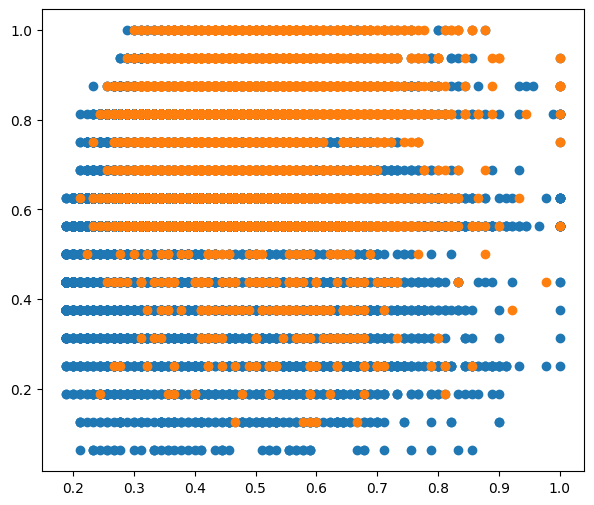

In [21]:
plt.figure(figsize=(7,6))
x_1=winner_group_class_1[:,0]
y_1=winner_group_class_1[:,1]
x_2=winner_group_class_2[:,0]
y_2=winner_group_class_2[:,1]
plt.scatter(x_1,y_1)
plt.scatter(x_2,y_2)
plt.show()

This is to plot in 3d when we have 3 features

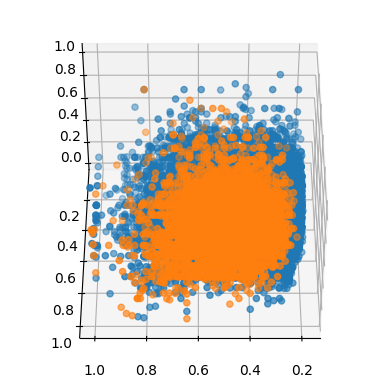

In [22]:
x_1=winner_group_class_1[:,0]
y_1=winner_group_class_1[:,1]
z_1=winner_group_class_1[:,2]
x_2=winner_group_class_2[:,0]
y_2=winner_group_class_2[:,1]
z_2=winner_group_class_2[:,2]

#3d plot
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d', elev=45, azim=90)
ax.scatter(x_1,y_1,z_1)
ax.scatter(x_2,y_2,z_2)
plt.show()


Test of Employees Data with feature selection into EM Model
=====

In [23]:
#------Inicial values----------------
#Note: the initial values are radom, but with with the correct constraints (Sigma covariance matrix must be positive definite...)
X_1_BigData=np.transpose(winner_group_class_1)
X_2_BigData=np.transpose(winner_group_class_2)

TotalClasses=[X_1_BigData,X_2_BigData]  #each of one has dim (feature,samples)

mu_1=np.array([(0.1),(0.2),(0.2)])
mu_2=np.array([(0.3),(0.4),(0.2)])

sigmas_1=np.identity(3)
sigmas_2=np.identity(3)

mus=(mu_1, mu_2)
sigmas=(sigmas_1,sigmas_2)
pis=(0.666, 0.333)
print(sigmas_1.shape)
mus,sigmas,pis=GaussianMixtureModel(mus,sigmas,pis,TotalClasses,NumberOfSteps=10)
print('los mus,sigmas y pis finales son:',mus,sigmas,pis)

(3, 3)
los mus,sigmas y pis finales son: [array([0.40793289, 0.60090196, 0.39813123]), array([0.49545353, 0.74445626, 0.46948905])] [array([[ 0.10557384, -0.00193626,  0.04394396],
       [-0.00193626,  0.14726232,  0.00280366],
       [ 0.04394396,  0.00280366,  0.08512528]]), array([[ 0.10059211,  0.00873754,  0.06634104],
       [ 0.00873754,  0.2029799 , -0.00493072],
       [ 0.06634104, -0.00493072,  0.11546176]])] [array([0.75254896]), array([7.85587253e-07])]


Testing EM algorith in Data set with feature selection previusly worked

Remember: if we select 3 features space, in 2D representation we're no seeing al information, but actually give us an idea

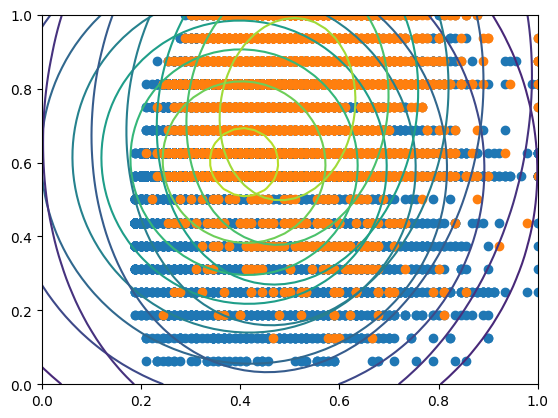

In [24]:

gaussianPltFunction(mus,sigmas)
x_1=winner_group_class_1[:,0]
y_1=winner_group_class_1[:,1]
x_2=winner_group_class_2[:,0]
y_2=winner_group_class_2[:,1]
plt.scatter(x_1,y_1)
plt.scatter(x_2,y_2)
plt.show()